<a href="https://colab.research.google.com/github/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/DNN_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# IMPORTS

import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing
device_name = tf.test.gpu_device_name()
display(device_name)

# data dirs
data_dir = '/content/drive/MyDrive/Adam Gibbs/data/'
model_dir = data_dir + 'models/'
training_dir=data_dir + 'training/'
# ship_dir = data_dir + 'ship/'
# glider_dir = data_dir + 'glider/'
# wcoa_dir = data_dir + 'wcoa/'

'/device:GPU:0'

In [3]:
# load in txt data

train_inputs = np.loadtxt(training_dir+'training_tpso_input.csv', 
                        delimiter=",", 
                        dtype='float')
train_outputs = np.loadtxt(training_dir+'training_ph_output.csv', 
                        delimiter=",", 
                        dtype='float')

val_inputs = np.loadtxt(training_dir+'validation_tpso_input.csv', 
                        delimiter=",", 
                        dtype='float')
val_outputs = np.loadtxt(training_dir+'validation_ph_output.csv', 
                        delimiter=",", 
                        dtype='float')

test_inputs = np.loadtxt(training_dir+'testing_tpso_input.csv', 
                        delimiter=",", 
                        dtype='float')
test_outputs = np.loadtxt(training_dir+'testing_ph_output.csv', 
                        delimiter=",", 
                        dtype='float')

display(train_inputs.shape)
display(train_outputs.shape)

display(val_inputs.shape)
display(val_outputs.shape)

display(test_inputs.shape)
display(test_outputs.shape)


(385716, 7)

(385716,)

(128572, 7)

(128572,)

(128572, 7)

(128572,)

In [4]:
test_results = {}

In [5]:
# CREATE NORMALIZER

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(train_inputs)


In [6]:
# METHOD TO BUILD AND COMPILE MODEL

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.00001),
                metrics=[
                         metrics.MeanAbsoluteError(),
                         metrics.MeanSquaredError(),
                         metrics.RootMeanSquaredError()
                ])
  return model

tf.config.list_physical_devices('GPU')

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,072
Trainable params: 13,057
Non-trainable params: 15
___________________________________________________

In [5]:
# LOAD IN MODELS

dnn_model = tf.keras.models.load_model(model_dir+'DNN(64,64,64,64)mse', compile=True)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,072
Trainable params: 13,057
Non-trainable params: 15
___________________________________________________

In [7]:
%%time
history = dnn_model.fit(
    train_inputs, train_outputs,
    validation_split=0.2, epochs=300)

Epoch 1/300
9643/9643 [==============================] - 34s 3ms/step - loss: 6.2585e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 6.2585e-05 - root_mean_squared_error: 0.0079 - val_loss: 7.8533e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 7.8533e-05 - val_root_mean_squared_error: 0.0089
Epoch 2/300
9643/9643 [==============================] - 28s 3ms/step - loss: 6.2226e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 6.2226e-05 - root_mean_squared_error: 0.0079 - val_loss: 8.7012e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 8.7012e-05 - val_root_mean_squared_error: 0.0093
Epoch 3/300
9643/9643 [==============================] - 27s 3ms/step - loss: 6.2556e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 6.2556e-05 - root_mean_squared_error: 0.0079 - val_loss: 6.2565e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 6.2565e-05 - val_root_mean_squared_error: 0.0079
Epoch 4/300
9643/9643 [=======================

In [9]:
test_results = {}
test_results['(64,64)_train'] = dnn_model.evaluate(train_inputs, train_outputs)
test_results['(64,64)_val'] = dnn_model.evaluate(val_inputs, val_outputs) 
test_results['(64,64)_val'] = dnn_model.evaluate(test_inputs, test_outputs) 

4018/4018 [==============================] - 8s 2ms/step - loss: 6.9039e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 6.9039e-05 - root_mean_squared_error: 0.0083


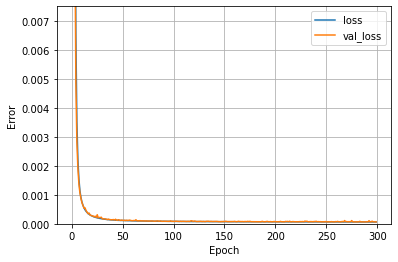

In [9]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim(0,0.001)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

120699


1

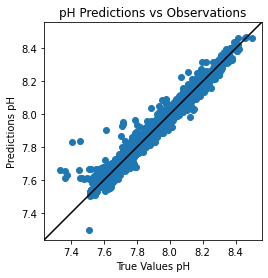

In [10]:
test_predictions = dnn_model.predict(test_inputs).flatten()

count = 0
ind = 0
for o in test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
    print(ind)
  ind += 1
display(count)


ax = plt.axes(aspect='equal')

plt.scatter(test_outputs, test_predictions)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.ylim(lims)
plt.xlim(lims)
plt.plot(lims,lims, color='black')

plt.title('pH Predictions vs Observations')
plt.xlabel('True Values pH')
plt.ylabel('Predictions pH')

plt.show()

In [12]:
dnn_model.save(model_dir+'DNN(64,64,64,64)mse')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Adam Gibbs/data/models/DNN(64,64,64,64)mse/assets
